In [1]:
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt

In [2]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        pass

class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.act_fn = nn.Tanh()
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.act_fn(x)
        x = self.layer2(x)
        return x

In [3]:
model = SimpleClassifier(input_dim=2, hidden_dim=4, output_dim=1)
print(model)

SimpleClassifier(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (layer2): Linear(in_features=4, out_features=1, bias=True)
)


In [4]:
for name, param in model.named_parameters():
    print(f"name: {name}, shape: {param.shape}")

name: layer1.weight, shape: torch.Size([4, 2])
name: layer1.bias, shape: torch.Size([4])
name: layer2.weight, shape: torch.Size([1, 4])
name: layer2.bias, shape: torch.Size([1])


In [5]:
import torch.utils.data as data
import torch

In [6]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()
    
    def generate_continuous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.std * torch.randn_like(data)
    
        self.data = data
        self.label = label

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        data_point = self.data[index]
        data_label = self.label[index]
        return data_point, data_label

In [7]:
dataset = XORDataset(size=200)
print(dataset[0])
print(len(dataset))

(tensor([0.0566, 0.9417]), tensor(1))
200


In [8]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if(isinstance(label, torch.Tensor)):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], c='r', edgecolor='k', label='class 0')
    plt.scatter(data_1[:,0], data_1[:,1], c='b', edgecolor='k', label='class 1')
    plt.title('Visualization of the dataset')
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.legend()

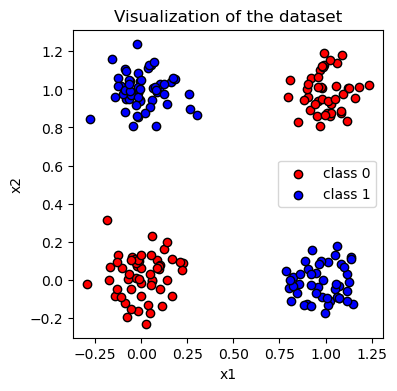

In [9]:
visualize_samples(dataset.data, dataset.label)

In [10]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

data_inputs, data_labels = next(iter(data_loader))
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 0.9718,  1.1033],
        [ 0.9070,  0.0581],
        [ 0.9233,  1.0607],
        [ 0.9849,  1.1197],
        [ 1.1602,  0.9552],
        [-0.0663,  1.0271],
        [-0.0884,  1.1077],
        [ 1.1226,  1.0091]])
Data labels torch.Size([8]) 
 tensor([0, 1, 0, 0, 0, 1, 1, 0])


In [11]:
loss_module = nn.BCEWithLogitsLoss()

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [13]:
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [14]:
model.to("mps")

SimpleClassifier(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (layer2): Linear(in_features=4, out_features=1, bias=True)
)

In [15]:
from tqdm import tqdm
from matplotlib.colors import to_rgba

In [16]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    model.train()

    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:

            data_inputs = data_inputs.to("mps")
            data_labels = data_labels.to("mps")

            preds = model(data_inputs)
            preds = preds.squeeze(dim = 1)

            loss = loss_module(preds, data_labels.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

train_model(model, optimizer, train_data_loader, loss_module)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 19.14it/s]


In [17]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('layer1.weight', tensor([[ 1.0956,  1.0153],
        [-3.3249,  3.0160],
        [-0.6392,  1.0264],
        [-2.6460,  2.9080]], device='mps:0')), ('layer1.bias', tensor([-2.2908,  1.6517, -0.3413, -1.5285], device='mps:0')), ('layer2.weight', tensor([[-2.3149, -4.6183,  0.8537,  4.0981]], device='mps:0')), ('layer2.bias', tensor([2.2734], device='mps:0'))])


In [18]:
torch.save(state_dict, "our_model.tar")

In [19]:
state_dict = torch.load("our_model.tar")
new_model = SimpleClassifier(input_dim=2, hidden_dim=4, output_dim=1)
new_model.load_state_dict(state_dict)

print("Original model state_dict:\n", model.state_dict())
print("Loaded model state_dict:\n", new_model.state_dict())


Original model state_dict:
 OrderedDict([('layer1.weight', tensor([[ 1.0956,  1.0153],
        [-3.3249,  3.0160],
        [-0.6392,  1.0264],
        [-2.6460,  2.9080]], device='mps:0')), ('layer1.bias', tensor([-2.2908,  1.6517, -0.3413, -1.5285], device='mps:0')), ('layer2.weight', tensor([[-2.3149, -4.6183,  0.8537,  4.0981]], device='mps:0')), ('layer2.bias', tensor([2.2734], device='mps:0'))])
Loaded model state_dict:
 OrderedDict([('layer1.weight', tensor([[ 1.0956,  1.0153],
        [-3.3249,  3.0160],
        [-0.6392,  1.0264],
        [-2.6460,  2.9080]])), ('layer1.bias', tensor([-2.2908,  1.6517, -0.3413, -1.5285])), ('layer2.weight', tensor([[-2.3149, -4.6183,  0.8537,  4.0981]])), ('layer2.bias', tensor([2.2734]))])


In [20]:
test_dataset = XORDataset(size=500)
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [21]:
def eval_model(model, data_loader):
    model.eval()
    true_preds, num_preds = 0., 0.

    with torch.no_grad():
        for data_inputs, data_labels in data_loader:

            data_inputs = data_inputs.to("mps")
            data_labels = data_labels.to("mps")

            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)
            pred_labels = (preds >= 0.5).long()

            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of model: {100.0*acc:4.2f}%")

eval_model(model, test_data_loader)

Accuracy of model: 100.00%


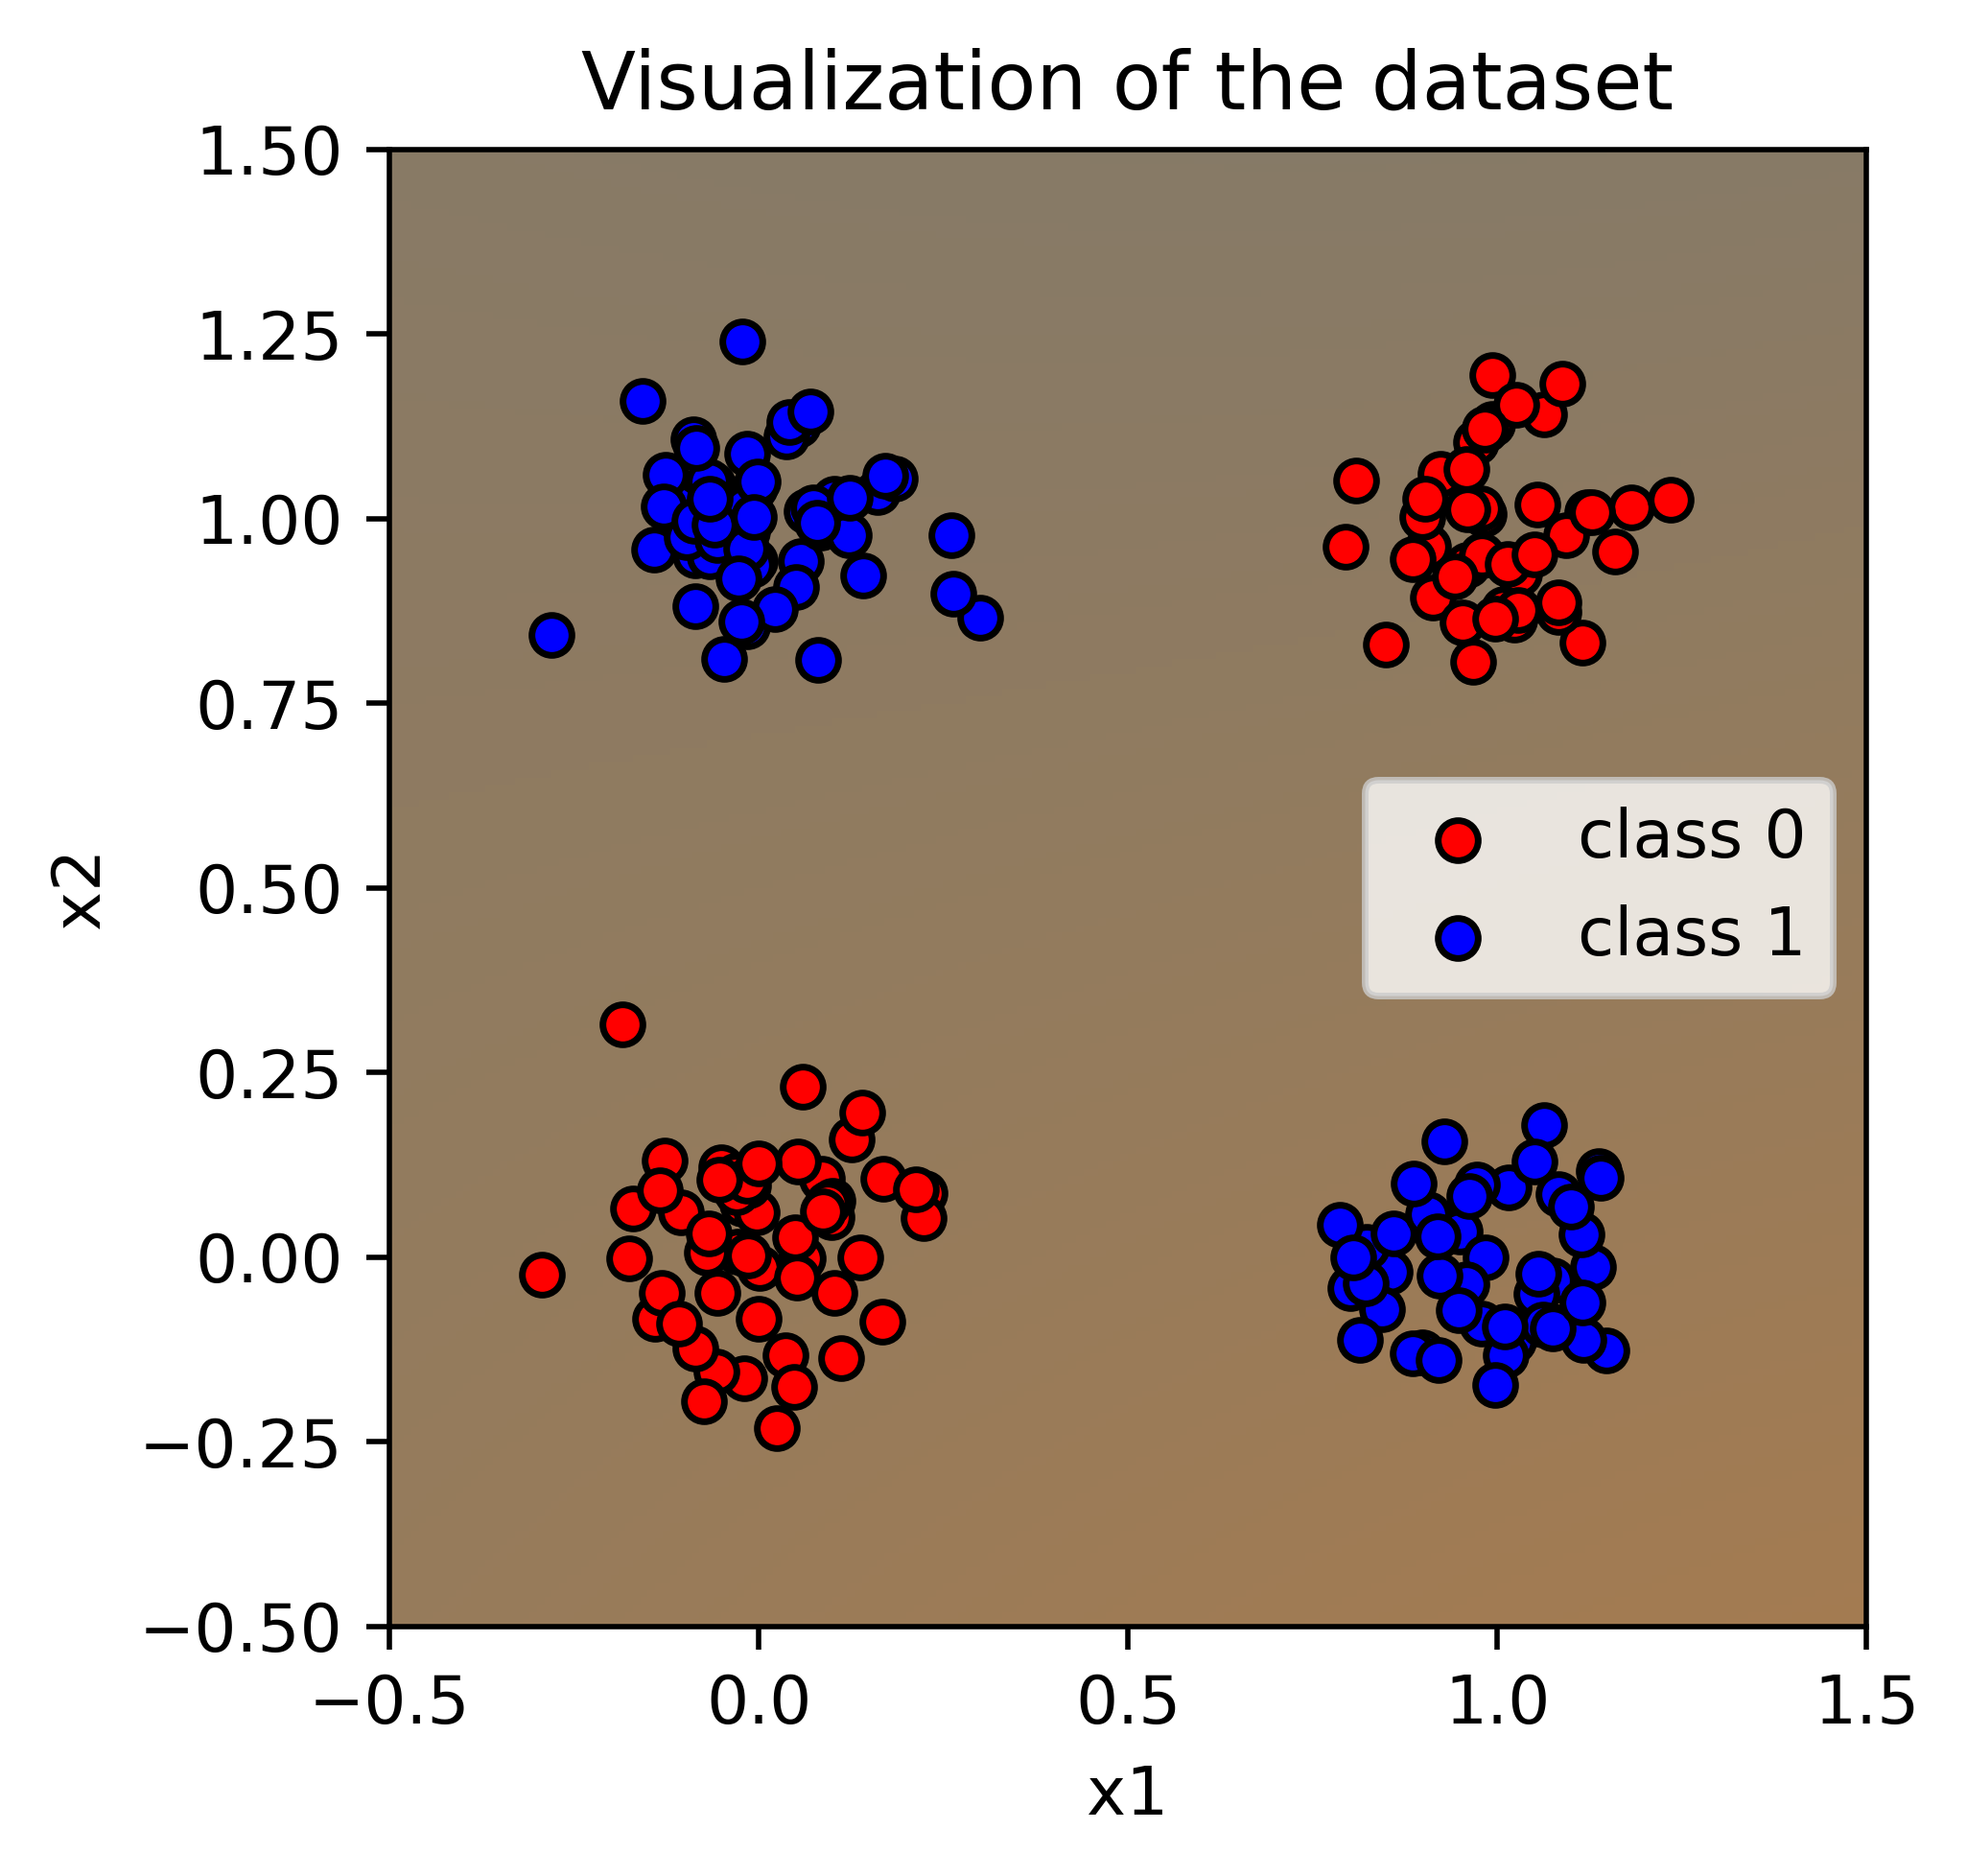

In [42]:
@torch.no_grad()
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if(isinstance(label, torch.Tensor)):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], c='r', edgecolor='k', label='class 0')
    plt.scatter(data_1[:,0], data_1[:,1], c='b', edgecolor='k', label='class 1')
    plt.title('Visualization of the dataset')
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.legend()

    model.to("mps")
    c0 = torch.Tensor(to_rgba("C0")).to("mps")
    c1 = torch.Tensor(to_rgba("C1")).to("mps")
    x1 = torch.arange(-0.5, 1.5, 0.01, device="mps")
    x2 = torch.arange(-0.5, 1.5, 0.01, device="mps")
    xx1, xx2 = torch.meshgrid(x1, x2, indexing="ij")
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1-preds) * c0[None, None] + preds * c1[None, None]
    output_image = output_image.cpu().numpy()
    plt.imshow(output_image, extent=(-0.5, 1.5, -0.5, 1.5), origin="lower")
    plt.grid(False)
    return fig

_ = visualize_classification(model, dataset.data, dataset.label)
plt.show()


In [28]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
from IPython.display import set_matplotlib_formats

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [46]:
def train_model_with_logger(model, optimizer, data_loader, loss_module, val_dataset, num_epochs=100, logging_dir="./runs/our_experiment"):
    writer = SummaryWriter(logging_dir)
    model_plotted = False

    model.train()

    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0.0
        for data_inputs, data_labels in data_loader:

            data_inputs = data_inputs.to("mps")
            data_labels = data_labels.to("mps")

            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True

            preds = model(data_inputs)
            preds = preds.squeeze(dim = 1)

            loss = loss_module(preds, data_labels.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(data_loader)
        writer.add_scalar("Loss/train", epoch_loss, global_step = epoch + 1)

        if (epoch + 1) % 10 == 0:
            fig = visualize_classification(model, val_dataset.data, val_dataset.label)
            writer.add_figure("predictions vs. actuals", fig, global_step=epoch+1)

    writer.close()

In [47]:
model = SimpleClassifier(input_dim=2, hidden_dim=4, output_dim=1)
model.to("mps")
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model_with_logger(model, optimizer, train_data_loader, loss_module, val_dataset=dataset)

100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


In [49]:
%tensorboard --logdir runs/our_experiment

Reusing TensorBoard on port 6006 (pid 35774), started 0:07:10 ago. (Use '!kill 35774' to kill it.)